In [32]:
import pandas as pd
import numpy as np

In [291]:
income_train = pd.read_csv('income_train.csv')
income_train.income = income_train.income.replace({'>50K': 1, '<=50K': 0})
income_train.head(8)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,33,Local-gov,198183,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,1
1,36,Private,86459,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,50,United-States,1
2,58,Self-emp-not-inc,203039,9th,5,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,0
3,21,Private,180190,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,46,United-States,0
4,27,Private,279872,Some-college,10,Divorced,Other-service,Not-in-family,White,Male,0,0,40,United-States,0
5,44,Private,175485,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,12,United-States,0
6,33,Private,67006,10th,6,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,45,United-States,0
7,62,Self-emp-not-inc,75478,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,0


In [52]:
income_train.groupby(['education', 'education-num']).agg({'income': 'mean'}).sort_values('income')

,,income
education,education-num,
Preschool,1,0.000000
1st-4th,2,0.041379
5th-6th,3,0.044280
11th,7,0.051579
9th,5,0.060150
10th,6,0.066667
7th-8th,4,0.067327
12th,8,0.083582
HS-grad,9,0.158032


In [55]:
income_train.groupby(['workclass']).agg({'income': 'mean'}).sort_values('income')

,income
workclass,
Never-worked,0.000000
Without-pay,0.000000
?,0.102972
Private,0.218678
State-gov,0.268199
Self-emp-not-inc,0.277533
Local-gov,0.297186
Federal-gov,0.391417
Self-emp-inc,0.557522


In [306]:
# Из выборки удаляются все объекты, содержащие значение хотя бы одного признака = "?"
income_train = income_train[(income_train == "?").sum(axis = 1) == 0].reset_index(drop = True)

### Преобразование категориальных признаков для решающего дерева
Было использовано следующее преобразование: значение каждого признака кодировались индексом, соответствующих индексу отсортированного массива долей объектов первого класса для каждого признака 

P. S. Эту часть тоже нужно запустить, это единственный энкодер для данной задачи

In [433]:
# Преобразование строковых данных в соответствии с правилом сортровки долей объектов класса 1
def tree_encoder(df, answers1, df_to_transform = None, answers2 = None, dtype = 'fit_transform'):
    df = df.drop('education', axis = 1) # Удаляется столбец "education", так как после преобразования он почти идентичен со столбцом "education-num"  
    df = pd.concat([df, answers1], axis = 1)
    ord_vars = df.columns[df.loc[0, :].map(lambda x: type(x) == str).values]
    for_test_encod = {}
    for v in ord_vars:
        sorted_val = df.groupby([v]).agg({'income': 'mean'}).sort_values('income').index
        change_dict = {x[0]: x[1] for x in zip(sorted_val, range(len(sorted_val)))}
        for_test_encod[v] = change_dict
        df = df.replace({v: change_dict})
    if dtype == 'fit_transform':
        return(df.drop('income', axis = 1))
    elif dtype == 'transform':
        df_2_t = df_to_transform.drop('education', axis = 1) 
        df_2_t = df_2_t.replace(for_test_encod)
        df_2_t = df_2_t[df_2_t[ord_vars].applymap(lambda x: type(x) == str).sum(axis = 1) == 0]
        if answers2 == None:
            return(df_2_t)
        else:
            return(df_2_t, answers2[df_2_t.index])

### Обучение случайного леса

In [349]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(income_train.drop('income', axis = 1), income_train.income, test_size = 0.3, random_state=1, shuffle = True, stratify = income_train.income)

In [352]:
X_train_scaled = tree_encoder(X_train, y_train)
X_test_scaled, y_test = tree_encoder(X_train, y_train, X_test, y_test, dtype = 'transform')

In [370]:
# Бейзлайн модели
from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train_scaled, y_train)
print('Правильность на обучающем наборе: {:.3f}'.format(rf_base.score(X_train_scaled, y_train)))
print('Правильность на тестовом наборе: {:.3f}'.format(rf_base.score(X_test_scaled, y_test)))

Правильность на обучающем наборе: 1.000
Правильность на тестовом наборе: 0.854


In [388]:
# Подбор параметров по сетке
from sklearn.model_selection import StratifiedKFold, GridSearchCV

rf = RandomForestClassifier(n_estimators=50, random_state=42, 
                             n_jobs=-1, oob_score=True)
skf = StratifiedKFold(n_splits = 5)
parameters = {'n_estimators': [300, 500], 'max_features': [7, 10, 13], 'min_samples_leaf': [1, 3, 5], 'max_depth': [15 , 20]}
gcv = GridSearchCV(rf, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'max_features': [7, 10, 13],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [300, 500]},
             verbose=1)

In [389]:
gcv.best_estimator_

RandomForestClassifier(max_depth=15, max_features=7, min_samples_leaf=3,
                       n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=42)

In [390]:
best_rf = gcv.best_estimator_.fit(X_train_scaled, y_train)
print('Правильность на обучающем наборе: {:.3f}'.format(best_rf.score(X_train_scaled, y_train)))
print('Правильность на тестовом наборе: {:.3f}'.format(best_rf.score(X_test_scaled, y_test)))

Правильность на обучающем наборе: 0.909
Правильность на тестовом наборе: 0.864


### Важность признаков

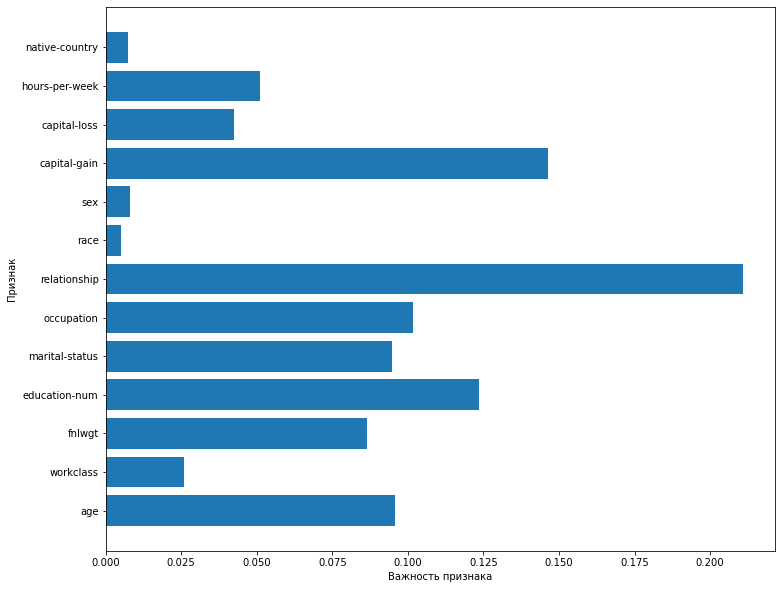

In [418]:
import matplotlib.pyplot as plt
def plot_feature_importances_cancer(df, model):
    n_features = df.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), np.array(df.columns)) 
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
plt.figure(figsize = (12, 10))
plot_feature_importances_cancer(X_train_scaled, best_rf)

#### Часть для проверки модели

In [444]:
income_train = pd.read_csv('income_train.csv')
income_train.income = income_train.income.replace({'>50K': 1, '<=50K': 0})
income_train = income_train[(income_train == "?").sum(axis = 1) == 0].reset_index(drop = True)
X_train_scaled = tree_encoder(income_train.drop('income', axis = 1), income_train.income)
y_train = income_train.income
X_train_scaled.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,33,4,198183,13,0,12,3,4,0,0,0,50,25
1,36,1,86459,11,6,13,4,4,1,0,1887,50,25
2,58,3,203039,5,1,8,3,4,1,0,0,40,25
3,21,1,180190,11,6,4,4,4,1,0,0,46,25
4,27,1,279872,10,4,2,3,4,1,0,0,40,25


In [445]:
X_test = pd.read_csv('test.csv')
X_test = X_test[(X_test == "?").sum(axis = 1) == 0]
X_test_scaled = tree_encoder(income_train.drop('income', axis = 1), income_train.income, X_test, dtype = 'transform')
X_test_scaled.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,27,1,160178,10,4,6,3,4,0,0,0,38,25
1,45,2,50567,9,6,13,5,4,0,0,0,40,25
2,29,1,185908,13,6,13,4,2,1,0,0,55,25
3,30,1,190040,13,0,5,3,4,0,0,0,40,25
4,29,3,189346,10,4,8,3,4,1,2202,0,50,25


In [446]:
best_model = RandomForestClassifier(max_depth=15, max_features=7, min_samples_leaf=3,
                       n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=42)
best_model.fit(X_train_scaled, y_train)
predicted_values = best_model.predict(X_test_scaled) # Здесь предсказанные значения для тестового набора
index_4_test = X_test_scaled.index # Здесь индексы для отбора ответов